In [1]:
from main import compute_inventory

filename = "data/exposure_conditions_divertor/WEST/Hao/P1.0e21_wall_data.mat"
# filename = "data/exposure_conditions_divertor/WEST/Julien/WPN54696-1.5MW-FESTIM_inputs.csv"
res = compute_inventory(filename)

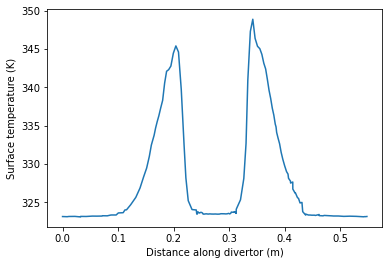

In [2]:
import matplotlib.pyplot as plt
arc_length_div = res.arc_length
T = res.temperature
plt.plot(arc_length_div, T)
xlabel = "Distance along divertor (m)"
plt.xlabel(xlabel)
plt.ylabel("Surface temperature (K)")
plt.show()

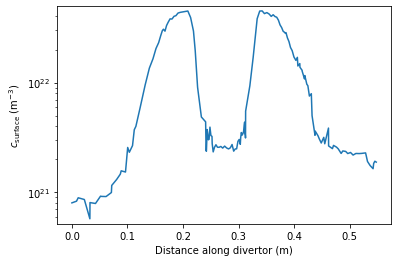

In [3]:
c_max = res.concentration
plt.yscale("log")
plt.ylim(min(c_max)*0.9, max(c_max)*1.1)

plt.plot(arc_length_div, c_max)

plt.xlabel(xlabel)
plt.ylabel("$c_\mathrm{surface}$ (m$^{-3}$)")
plt.show()

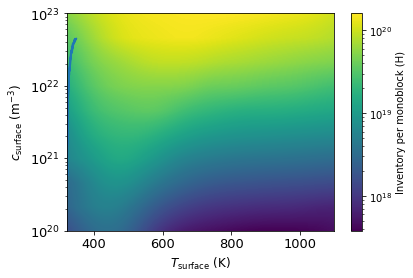

In [4]:
from matplotlib import ticker
import numpy as np

inv_T_c = res.interp_inv
x = np.linspace(320, 1100, num=50)
y = np.logspace(20, 23, num=10)

XX, YY = np.meshgrid(x, y)

values = np.zeros(XX.shape)
min_value, max_value = np.float("inf"), np.float("-inf")
for i in range(len(XX)):
    for j in range(len(XX[i])):
        if XX[i][j] < 1200:
            val = inv_T_c(XX[i][j], YY[i][j])
            values[i][j] = val
            min_value = min(min_value, float(val))
            max_value = max(max_value, float(val))
locator = ticker.LogLocator(base=10)
levels = np.logspace(
    np.log10(min_value),
    np.log10(max_value),
    1000)
# plot the inventory contour
CS = plt.contourf(XX, YY, values, locator=locator, levels=levels)

# plot the current case
plt.plot(T, c_max)

plt.colorbar(CS, label=r"Inventory per monoblock (H)", ticks=locator)
plt.yscale("log")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel(r"$T_\mathrm{surface}$ (K)", fontsize=12)
plt.ylabel(r"$c_\mathrm{surface}$ (m$^{-3}$)", fontsize=12)
plt.show()

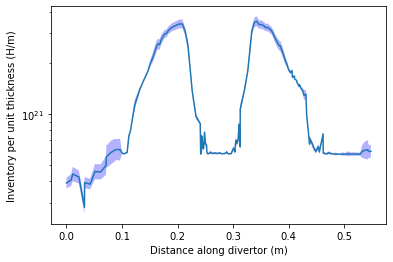

In [5]:
e = 12e-3  # monoblock thickness (m)
inventories = res.inventory  # inventory in H/m
sigmas = res.sigma_inv

plt.plot(arc_length_div, inventories)

plt.fill_between(
    arc_length_div, 10**(2*sigmas + np.log10(inventories)), 10**(-2*sigmas + np.log10(inventories)),
    facecolor='blue', alpha=0.3)
plt.xlabel(xlabel)
plt.yscale("log")
plt.ylabel("Inventory per unit thickness (H/m)")
plt.savefig("Inventory per monoblock.pdf")
plt.show()

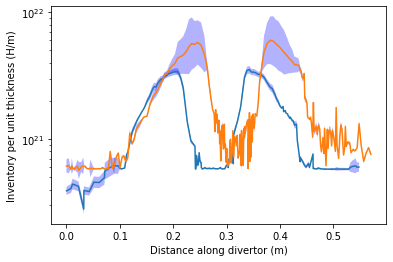

In [6]:
filenames = [
    "data/exposure_conditions_divertor/WEST/Hao/P1.0e21_wall_data.mat",
    "data/exposure_conditions_divertor/WEST/Julien/WPN54696-1.5MW-FESTIM_inputs.csv"
]

for filename in filenames:
    res = compute_inventory(filename)
    inventories = res.inventory  # inventory in H/m
    sigmas = res.sigma_inv
    plt.plot(res.arc_length, inventories)

    plt.fill_between(
        res.arc_length, 10**(2*sigmas + np.log10(inventories)), 10**(-2*sigmas + np.log10(inventories)),
        facecolor='blue', alpha=0.3)

plt.xlabel(xlabel)
plt.yscale("log")
plt.ylabel("Inventory per unit thickness (H/m)")
plt.savefig("Inventory per monoblock.pdf")
plt.show()